<a href="https://colab.research.google.com/github/Song-Jun-Ho/VGGNet/blob/main/vggnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Function

In [ ]:
import numpy as np

def Convolution(image, filter, stride=1, padding=0):
    """
    Inputs
    - image: 2D numpy array 
    - filter: 2D numpy array
    - stride, padding: integers

    Outputs:
    - 2D numpy array : convolution results of the given image and filter..
    - Return None if stride is not compatible. (ex. image of 5*5 with filter 2*2 with stride 2, padding 0)
    - Return None if filter is larger than the given image.
    """
    H, W = image.shape
    FH, FW = filter.shape
    out_H = (H - FH + 2*padding)//stride + 1
    out_W = (W - FW + 2*padding)//stride + 1
    output = np.zeros((out_H, out_W))
    
    if (H - FH + 2*padding) % stride != 0 or (W - FW + 2*padding) % stride != 0:
        return None

    if padding != 0:
        image = np.pad(image, ((padding, padding), (padding, padding)), 'constant', constant_values=0)
    
    for i in range(out_H):
        for j in range(out_W):
            output[i, j] = np.sum(image[i*stride:i*stride+FH, j*stride:j*stride+FW] * filter)
    
    return output

In [ ]:
Convolution(np.array([[1, 2, 3, 2, 1], [2, 3, 4, 5, 6], [-1, -2, -3, -4, -5], [0, 0, 1, 0, 0], [7, 1, 7, 1, 7]]), np.array([[1, 0], [0, 1]]), stride=3, padding=0)
## Expected result:
# array([[4., 8.],
#        [1., 7.]])

array([[4., 8.],
       [1., 7.]])

# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""
# %cd 'COPY&PASTE FILE DIRECTORY HERE'

'\nChange directory to where this file is located\n'

# Import Modules

In [ ]:
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [ ]:
"""
import modules you need
"""
import random


# Utils

In [ ]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this function.
    """
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

In [ ]:
def train(model, train_loader, optimizer, scheduler=None):
    """
    Trains the model with training data.

    Do NOT modify this function.
    """
    model.train()
    correct = 0
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        predictions = output.max(1, keepdim=True)[1]
        correct += predictions.eq(label.view_as(predictions)).sum().item()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    train_accuracy = 100. * correct / len(train_loader.dataset)
    if scheduler is not None:
        scheduler.step()
    return train_accuracy

def evaluate(model, test_loader):
    """
    Evaluates the trained model with test data.

    Do NOT modify this function.
    """
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# CIFAR-10 Data Augmentation

In [ ]:
def gaussian_smoothing(image, filter_size=3, sigma=1.0):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    center = (filter_size-1)/2
    gaussian_filter = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        for col in range(filter_size):
            gaussian_filter[row, col] = np.exp((-(row-center) ** 2 - (col-center) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)
    image = cv2.filter2D(image, -1, gaussian_filter)
    return image

def color_jitter(image):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return image

def custom_augmentation(image):
    """
      Define your own augmentation without using neural network libraries.

      Inputs
      - image: an input image of shape (3,32,32).
      Returns
      - image: image after applying your custom augmentation.
    """
    ### COMPLETE HERE ###
    image = cv2.flip(image, 1)

    ### COMPLETE HERE ###

    return image

def random_crop(image, value=0.5):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0.')
        return image
    value = random.uniform(value, 1)
    h, w = image.shape[:2]
    h_taken = int(h*value)
    w_taken = int(w*value)
    h_start = random.randint(0, h - h_taken)
    w_start = random.randint(0, w - w_taken)
    image = image[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    image = cv2.resize(image, (h, w), cv2.INTER_CUBIC)

    return image
    

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


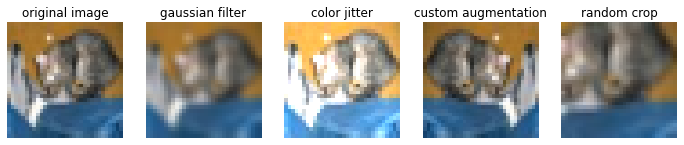

In [ ]:
"""
Visualize how the augmentations are applied to a single image.
You can run this block of code to check how your custom augmentation function from (b) is applied.

Do NOT modify.
"""

raw_test = datasets.CIFAR10(root="./CIFAR_10", train=False, download=True)

f, ax = plt.subplots(1, 5)
f.set_size_inches(12, 3)
x = raw_test[0][0]
x = np.array(x)
g = gaussian_smoothing(x)
j = color_jitter(x)
c = custom_augmentation(x)
r = random_crop(x)
title = ['original image', 'gaussian filter', 'color jitter', 'custom augmentation', 'random crop']
for i, img in enumerate([x, g, j, c, r]):
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(title[i], color='k')

Write your answer to question (b) in this cell.

In [ ]:
data = datasets.CIFAR10(root='./CIFAR_10', train=True, download=True)
x = np.stack([np.asarray(data[i][0]) for i in range(len(data))])
mean = np.mean(x, axis=(0, 1, 2))
std = np.std(x, axis=(0, 1, 2))
mean, std

Files already downloaded and verified


(array([125.30691805, 122.95039414, 113.86538318]),
 array([62.99321928, 62.08870764, 66.70489964]))

In [ ]:
x.shape

(50000, 32, 32, 3)

In [ ]:
len(data)

50000

In [ ]:
data[0]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F51A8137090>, 6)

In [ ]:
p1, p2, p3 =np.random.rand(3)
p1, p2, p3

(0.26201757628613864, 0.2443102737032452, 0.6701312262804301)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train, mean, std, prob=0.5, data_dir="./CIFAR_10"):
        """
        Do NOT modify this method.
        """
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.prob = prob
        self.mean = mean
        self.std = std

    def __len__(self):
        """
        Do NOT modify this method.
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Do NOT modify this method.
        """
        return self.data[idx]
    
    def transform(self, image):
        """
          Apply stochastic data augmentation to the given image.

          - Convert the given RGB image into BGR scale using opencv library.
          - Apply random augmentation (gaussian smoothing and color jitter, custom_augmentation if implemented).
            - Random augmentation is applied with the probability of self.prob.
            - If self.prob = 0.5, 5 out of 10 images will be augmented on average.
          - Convert the augmented image back to RGB scale for training.

          Inputs
          - image: numpy array of an input image of shape (32,32,3).
          Returns
          - image: numpy array of the augmented input image with shape (32,32,3).
        """
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        ### COMPLETE HERE ###
        # if np.random.rand() <= self.prob:
        #     image = gaussian_smoothing(image)
        # if np.random.rand() <= self.prob:
        #     image = color_jitter(image)
        if np.random.rand() <= self.prob:
            image = custom_augmentation(image)
        if np.random.rand() <= self.prob:
            image = random_crop(image)
        ### COMPLETE HERE ###
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def collate_fn(self, data):
        """
        Creates a batch of images and label tensors.

        - Convert each image in the batch from PIL image to numpy array.
        - Transform the image using self.transform method to apply random augmentation.
        - Normalize the transformed image by mapping the range [0, 255] to range [0, 1].
        - Transpose the (H * W * C) format of the image into (C * H * W) format.
          - To be specific, the dimension of the original image is (32, 32, 3).
          - We want the dimension of the transposed image to be (3, 32, 32).
        - Convert the batch of preprocessed images into PyTorch float tensors.
        - Convert the batch of labels into PyTorch long tensors.
        - Do NOT use torchvision.transforms library!

        Inputs
        - list of tuples, each containing a PIL image and an integer label
        - number of tuples in the list == BATCH SIZE
        Returns
        - batch of image tensors, batch of label tensors
        - size: (BATCH, CHANNEL, HEIGHT, WIDTH), (BATCH)
        """
        batch_x, batch_y = [], []

        for x, y in data:
            x = np.array(x)
            # x = (x-self.mean)/self.std
            x = self.transform(x)
            x = torch.tensor((x - self.mean)/(self.std + 1e-7)).permute(2,0,1)
            # x = torch.tensor(x).permute(2,0,1)
            y = torch.Tensor([y])
            batch_x.append(x)
            batch_y.append(y)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.cat(batch_y).long()
        
        return batch_x, batch_y
    

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

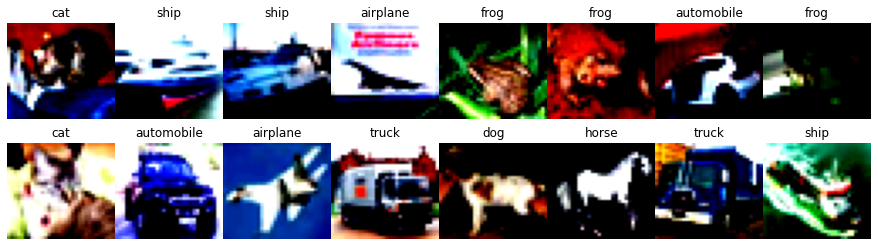

In [ ]:
"""
Plot some example images and class labels without applying data augmentation.

Do NOT modify.
"""

raw_test_dataset = CustomDataset(train=False, mean=mean, std=std, prob=0, data_dir="./CIFAR_10")
raw_test_loader = DataLoader(dataset=raw_test_dataset, batch_size=16, shuffle=False, collate_fn=raw_test_dataset.collate_fn)

plot_dataset(raw_test_loader)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

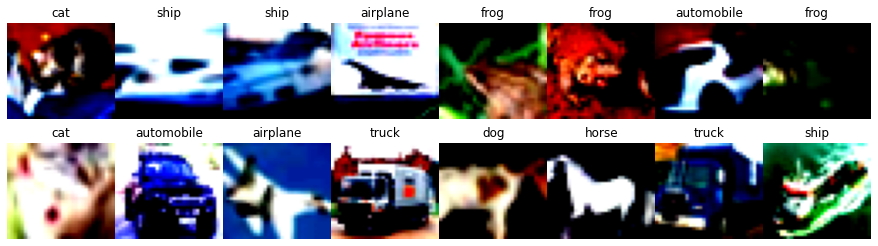

In [ ]:
"""
Same examples after applying data augmentation with 50% probability.

Do NOT modify.
"""

train_dataset = CustomDataset(train=True, mean=mean, std=std, prob=0.5)
test_dataset = CustomDataset(train=False, mean=mean, std=std, prob=0.5)

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         collate_fn=test_dataset.collate_fn)

plot_dataset(test_loader)

# ConvNet Image Classification

In [ ]:
x = torch.rand(32, 32, 16, 16)
x = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')(x)
x = nn.BatchNorm2d(64)(x)
x = nn.ReLU()(x)
x = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same', bias=False)(x)
x = nn.BatchNorm2d(64)(x)
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1)(x)
print(x.shape)

torch.Size([32, 64, 8, 8])


In [ ]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M',
          512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
          'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M',
          512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

# A : VGG-11
# B : VGG-13
# D : VGG-16
# E : VGG-19

In [ ]:
def make_layer(config):
    layers = []
    in_planes = 3
    for value in config:
        if value == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3,
                                    padding=1))
            layers.append(nn.BatchNorm2d(value))
            layers.append(nn.ReLU(inplace=True))
            in_planes = value
    layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
    return nn.Sequential(*layers)

In [ ]:
class ConvNet(nn.Module):
    """
    Builds a ConvNet model.

    """
    def __init__(self, config):
        """
        Define the layers that you would like to use in your model.
        """
        super(ConvNet, self).__init__()

        self.features = make_layer(config)
        # self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        """
        Apply forward pass of the given batch of input images.
        Inputs
        - x: batch of input images.
        Returns
        - softmax probabilites of the input image for each class label
        """

        out = self.features(x)
        out = out.view(-1, 512)
        # out = self.dropout(out)
        out = self.classifier(out)

        return out

In [ ]:
x = torch.rand(32, 3, 32, 32)
x = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')(x)
x = nn.BatchNorm2d(64)(x)
x = nn.ReLU()(x)
x = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same', bias=False)(x)
x = nn.BatchNorm2d(64)(x)
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
print(x.shape)

torch.Size([32, 64, 8, 8])


In [ ]:
"""
Make sure your runtime type is GPU and you are using PyTorch version higher than 1.8!

Do NOT modify.
"""

DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 1.11.0+cu113, Device: cuda


In [ ]:
"""
Load your customized model "ConvNet" and its training settings.
You may choose the number of epochs that you would like to train.
You might want to use different optimizers or learning rates.
"""

EPOCHS = 200
model = ConvNet(config=cfg['D']).to(DEVICE)
# model = ConvNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, )
criterion = nn.CrossEntropyLoss()

# adding lr scheduler
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR
from torch.optim.lr_scheduler import StepLR as StepLR
from torch.optim.lr_scheduler import OneCycleLR as OneCycleLR
from torch.optim.lr_scheduler import CosineAnnealingLR as CosineAnnealingLR
from torch.optim.lr_scheduler import MultiStepLR as MultiStepLR
#scheduler = ExponentialLR(optimizer, gamma=0.9)
# scheduler = StepLR(optimizer, step_size=20, gamma=1/3)
scheduler = MultiStepLR(optimizer, milestones=[20, 40, 60, 100], gamma=1/3)
# scheduler = OneCycleLR(optimizer, max_lr=0.12, steps_per_epoch=len(train_loader),
#                        epochs=50, anneal_strategy='linear', div_factor=15, final_div_factor=10)

print(model)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128,

In [ ]:
x = torch.rand(1, 3, 32, 32).to(DEVICE)
out = model(x)
out

tensor([[ 0.0381,  0.0211,  0.0082,  0.0099, -0.0167, -0.0254, -0.0204, -0.0431,
          0.0308, -0.0119]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
x = torch.rand(1, 3, 32, 32).to(DEVICE)
out = model(x)
out

tensor([[ 0.0420,  0.0494,  0.0101,  0.0183, -0.0062, -0.0281, -0.0097, -0.0339,
         -0.0123,  0.0034]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# scheduler = None

In [ ]:
"""
Train your model "ConvNet" with the augmented CIFAR-10 dataset.
Upon successful training, test accuracy of your model should be above 70%.

Do NOT modify.
"""
# EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    train_accuracy = train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: ConvNet, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % , \tTrain Accuracy: {:.2f} % \n".
          format(epoch, test_loss, test_accuracy, train_accuracy))

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: ConvNet, 	Test Loss: 0.0191, 	Test Accuracy: 26.01 % , 	Train Accuracy: 24.60 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: ConvNet, 	Test Loss: 0.0185, 	Test Accuracy: 27.73 % , 	Train Accuracy: 29.99 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: ConvNet, 	Test Loss: 0.0176, 	Test Accuracy: 29.18 % , 	Train Accuracy: 32.17 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: ConvNet, 	Test Loss: 0.0176, 	Test Accuracy: 30.58 % , 	Train Accuracy: 33.37 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: ConvNet, 	Test Loss: 0.0154, 	Test Accuracy: 41.37 % , 	Train Accuracy: 38.70 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: ConvNet, 	Test Loss: 0.0147, 	Test Accuracy: 46.48 % , 	Train Accuracy: 47.62 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: ConvNet, 	Test Loss: 0.0143, 	Test Accuracy: 46.45 % , 	Train Accuracy: 53.41 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: ConvNet, 	Test Loss: 0.0140, 	Test Accuracy: 49.94 % , 	Train Accuracy: 56.19 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: ConvNet, 	Test Loss: 0.0133, 	Test Accuracy: 51.28 % , 	Train Accuracy: 58.64 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: ConvNet, 	Test Loss: 0.0119, 	Test Accuracy: 56.96 % , 	Train Accuracy: 59.98 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 11], 	Model: ConvNet, 	Test Loss: 0.0119, 	Test Accuracy: 57.93 % , 	Train Accuracy: 61.22 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 12], 	Model: ConvNet, 	Test Loss: 0.0111, 	Test Accuracy: 60.49 % , 	Train Accuracy: 62.10 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 13], 	Model: ConvNet, 	Test Loss: 0.0114, 	Test Accuracy: 59.86 % , 	Train Accuracy: 62.74 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 14], 	Model: ConvNet, 	Test Loss: 0.0120, 	Test Accuracy: 57.00 % , 	Train Accuracy: 63.09 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 15], 	Model: ConvNet, 	Test Loss: 0.0122, 	Test Accuracy: 56.25 % , 	Train Accuracy: 63.79 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 16], 	Model: ConvNet, 	Test Loss: 0.0117, 	Test Accuracy: 58.50 % , 	Train Accuracy: 64.47 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 17], 	Model: ConvNet, 	Test Loss: 0.0107, 	Test Accuracy: 62.76 % , 	Train Accuracy: 65.02 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 18], 	Model: ConvNet, 	Test Loss: 0.0116, 	Test Accuracy: 60.04 % , 	Train Accuracy: 64.82 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 19], 	Model: ConvNet, 	Test Loss: 0.0103, 	Test Accuracy: 64.19 % , 	Train Accuracy: 65.38 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 20], 	Model: ConvNet, 	Test Loss: 0.0101, 	Test Accuracy: 65.35 % , 	Train Accuracy: 65.31 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 21], 	Model: ConvNet, 	Test Loss: 0.0086, 	Test Accuracy: 70.59 % , 	Train Accuracy: 69.74 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 22], 	Model: ConvNet, 	Test Loss: 0.0090, 	Test Accuracy: 69.05 % , 	Train Accuracy: 70.57 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 23], 	Model: ConvNet, 	Test Loss: 0.0091, 	Test Accuracy: 68.65 % , 	Train Accuracy: 70.97 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 24], 	Model: ConvNet, 	Test Loss: 0.0094, 	Test Accuracy: 67.40 % , 	Train Accuracy: 71.09 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 25], 	Model: ConvNet, 	Test Loss: 0.0085, 	Test Accuracy: 70.74 % , 	Train Accuracy: 71.34 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 26], 	Model: ConvNet, 	Test Loss: 0.0087, 	Test Accuracy: 70.15 % , 	Train Accuracy: 71.87 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 27], 	Model: ConvNet, 	Test Loss: 0.0083, 	Test Accuracy: 71.10 % , 	Train Accuracy: 71.88 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 28], 	Model: ConvNet, 	Test Loss: 0.0092, 	Test Accuracy: 67.93 % , 	Train Accuracy: 72.29 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 29], 	Model: ConvNet, 	Test Loss: 0.0081, 	Test Accuracy: 72.18 % , 	Train Accuracy: 72.42 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 30], 	Model: ConvNet, 	Test Loss: 0.0087, 	Test Accuracy: 70.46 % , 	Train Accuracy: 72.62 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 31], 	Model: ConvNet, 	Test Loss: 0.0085, 	Test Accuracy: 70.39 % , 	Train Accuracy: 72.78 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 32], 	Model: ConvNet, 	Test Loss: 0.0084, 	Test Accuracy: 71.20 % , 	Train Accuracy: 72.67 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 33], 	Model: ConvNet, 	Test Loss: 0.0083, 	Test Accuracy: 71.83 % , 	Train Accuracy: 73.04 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 34], 	Model: ConvNet, 	Test Loss: 0.0086, 	Test Accuracy: 71.01 % , 	Train Accuracy: 72.94 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 35], 	Model: ConvNet, 	Test Loss: 0.0086, 	Test Accuracy: 70.14 % , 	Train Accuracy: 73.21 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 36], 	Model: ConvNet, 	Test Loss: 0.0096, 	Test Accuracy: 68.10 % , 	Train Accuracy: 73.52 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 37], 	Model: ConvNet, 	Test Loss: 0.0084, 	Test Accuracy: 71.61 % , 	Train Accuracy: 73.37 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 38], 	Model: ConvNet, 	Test Loss: 0.0086, 	Test Accuracy: 70.39 % , 	Train Accuracy: 73.69 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 39], 	Model: ConvNet, 	Test Loss: 0.0080, 	Test Accuracy: 72.65 % , 	Train Accuracy: 73.62 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 40], 	Model: ConvNet, 	Test Loss: 0.0081, 	Test Accuracy: 72.64 % , 	Train Accuracy: 73.86 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 41], 	Model: ConvNet, 	Test Loss: 0.0073, 	Test Accuracy: 74.65 % , 	Train Accuracy: 75.73 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 42], 	Model: ConvNet, 	Test Loss: 0.0072, 	Test Accuracy: 75.57 % , 	Train Accuracy: 76.41 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 43], 	Model: ConvNet, 	Test Loss: 0.0072, 	Test Accuracy: 75.63 % , 	Train Accuracy: 76.75 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 44], 	Model: ConvNet, 	Test Loss: 0.0071, 	Test Accuracy: 75.76 % , 	Train Accuracy: 76.71 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 45], 	Model: ConvNet, 	Test Loss: 0.0072, 	Test Accuracy: 75.83 % , 	Train Accuracy: 76.94 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 46], 	Model: ConvNet, 	Test Loss: 0.0071, 	Test Accuracy: 75.83 % , 	Train Accuracy: 77.12 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 47], 	Model: ConvNet, 	Test Loss: 0.0074, 	Test Accuracy: 74.69 % , 	Train Accuracy: 77.13 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 48], 	Model: ConvNet, 	Test Loss: 0.0074, 	Test Accuracy: 75.26 % , 	Train Accuracy: 77.15 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 49], 	Model: ConvNet, 	Test Loss: 0.0070, 	Test Accuracy: 76.45 % , 	Train Accuracy: 77.36 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 50], 	Model: ConvNet, 	Test Loss: 0.0073, 	Test Accuracy: 75.33 % , 	Train Accuracy: 77.22 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 51], 	Model: ConvNet, 	Test Loss: 0.0071, 	Test Accuracy: 76.19 % , 	Train Accuracy: 77.39 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 52], 	Model: ConvNet, 	Test Loss: 0.0074, 	Test Accuracy: 75.05 % , 	Train Accuracy: 77.39 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 53], 	Model: ConvNet, 	Test Loss: 0.0070, 	Test Accuracy: 76.22 % , 	Train Accuracy: 77.50 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 54], 	Model: ConvNet, 	Test Loss: 0.0074, 	Test Accuracy: 74.87 % , 	Train Accuracy: 77.42 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 55], 	Model: ConvNet, 	Test Loss: 0.0070, 	Test Accuracy: 76.53 % , 	Train Accuracy: 77.59 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 56], 	Model: ConvNet, 	Test Loss: 0.0074, 	Test Accuracy: 75.32 % , 	Train Accuracy: 77.73 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 57], 	Model: ConvNet, 	Test Loss: 0.0073, 	Test Accuracy: 74.97 % , 	Train Accuracy: 77.86 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 58], 	Model: ConvNet, 	Test Loss: 0.0070, 	Test Accuracy: 76.72 % , 	Train Accuracy: 77.75 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 59], 	Model: ConvNet, 	Test Loss: 0.0071, 	Test Accuracy: 76.02 % , 	Train Accuracy: 77.73 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 60], 	Model: ConvNet, 	Test Loss: 0.0073, 	Test Accuracy: 74.96 % , 	Train Accuracy: 77.86 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 61], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 77.47 % , 	Train Accuracy: 78.84 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 62], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 76.88 % , 	Train Accuracy: 79.23 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 63], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 77.01 % , 	Train Accuracy: 79.53 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 64], 	Model: ConvNet, 	Test Loss: 0.0069, 	Test Accuracy: 76.46 % , 	Train Accuracy: 79.25 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 65], 	Model: ConvNet, 	Test Loss: 0.0069, 	Test Accuracy: 76.82 % , 	Train Accuracy: 79.64 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 66], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.53 % , 	Train Accuracy: 79.64 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 67], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 76.95 % , 	Train Accuracy: 79.27 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 68], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.49 % , 	Train Accuracy: 79.48 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 69], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.12 % , 	Train Accuracy: 79.55 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 70], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.52 % , 	Train Accuracy: 79.61 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 71], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.16 % , 	Train Accuracy: 79.64 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 72], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 77.31 % , 	Train Accuracy: 79.93 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 73], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 77.26 % , 	Train Accuracy: 79.85 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 74], 	Model: ConvNet, 	Test Loss: 0.0066, 	Test Accuracy: 77.29 % , 	Train Accuracy: 79.46 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 75], 	Model: ConvNet, 	Test Loss: 0.0069, 	Test Accuracy: 76.71 % , 	Train Accuracy: 79.90 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 76], 	Model: ConvNet, 	Test Loss: 0.0068, 	Test Accuracy: 77.29 % , 	Train Accuracy: 79.69 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 77], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.11 % , 	Train Accuracy: 79.89 % 



0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


[EPOCH: 78], 	Model: ConvNet, 	Test Loss: 0.0067, 	Test Accuracy: 77.53 % , 	Train Accuracy: 80.13 % 



0it [00:00, ?it/s]